In [7]:
from __future__ import annotations
import os
from pathlib import Path
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, lowdin_rotation
from qtpyt.basis import Basis

import matplotlib.pyplot as plt

In [2]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)


In [3]:
data_folder = './output/lowdin'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

GPWDEVICEDIR = './dft/device/'
GPWLEADSDIR = './dft/leads/'
SUBDIAG_SPECIES = ("C", "N", "H")
active = {'C': [3],'N': [3]}


cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

In [4]:
lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao


Condition number: 2.8e+04


In [39]:
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]


Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)
H_subdiagonalized_no_lowdin = rotate_matrix(H_lcao, Usub)
S_subdiagonalized_no_lowdin = rotate_matrix(S_lcao, Usub)


In [40]:
lowdin = True
if lowdin:
    print("Lowdin rotation")
    Ulow = lowdin_rotation(H_subdiagonalized_no_lowdin, S_subdiagonalized_no_lowdin, index_active_region)

    H_subdiagonalized_lowdin = rotate_matrix(H_subdiagonalized_no_lowdin, Ulow)
    S_subdiagonalized_lowdin = rotate_matrix(S_subdiagonalized_no_lowdin, Ulow)


Lowdin rotation


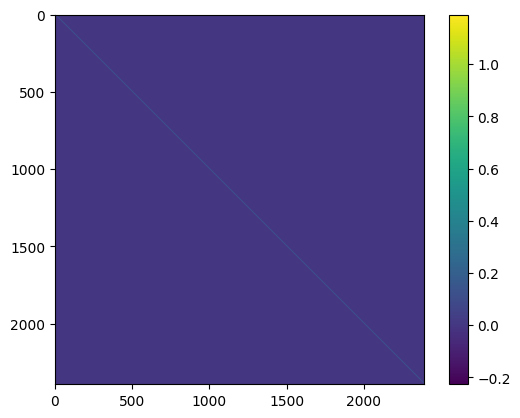

In [47]:
plt.imshow(Ulow)
plt.colorbar()

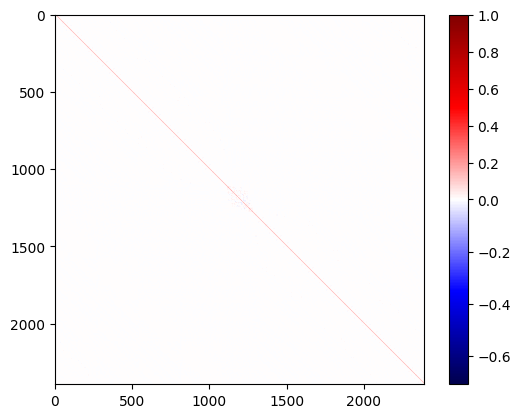

In [41]:
from matplotlib.colors import TwoSlopeNorm

# Define normalization centered at 0
norm = TwoSlopeNorm(vmin=S_subdiagonalized_no_lowdin.min(), vcenter=0, vmax=S_subdiagonalized_no_lowdin.max())
cmap = plt.cm.seismic  # Diverging colormap

plt.imshow(S_subdiagonalized_no_lowdin, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

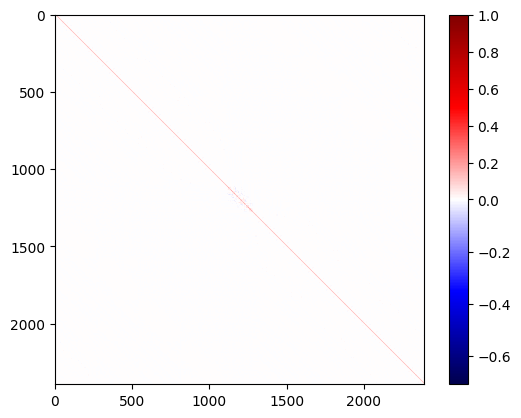

In [42]:
plt.imshow(S_lcao, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [43]:
np.allclose(S_subdiagonalized_no_lowdin, np.eye(S_subdiagonalized_no_lowdin.shape[0]), atol=1)

True

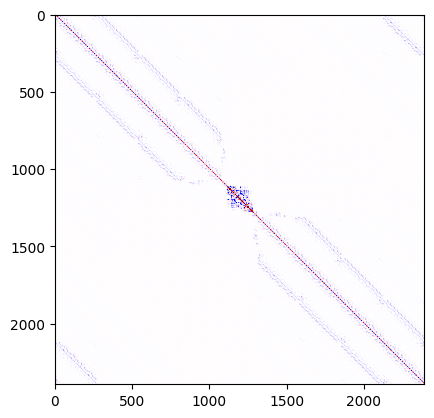

In [44]:
plt.imshow(H_subdiagonalized_no_lowdin, cmap=cmap, norm=norm)

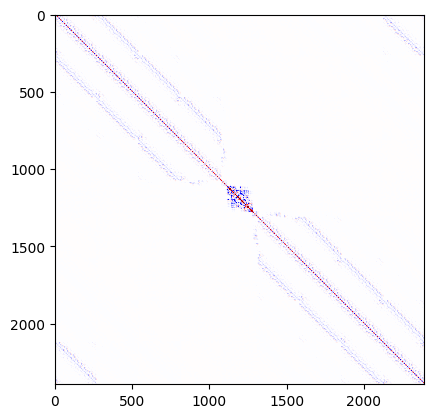

In [45]:
plt.imshow(H_subdiagonalized_lowdin, cmap=cmap, norm=norm)